# Sample Neural Network Pre-Work

## Import Modules

In [ ]:
# For EVERYTHING
import numpy as np
import pandas as pd

# For preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# For accuracy
from sklearn.metrics import mean_squared_error
from statistics import mean

# For data structs
from typing import Dict, List, Tuple

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt

## Define Classes and Methods

In [ ]:
# Define the NN class

np.random.seed(42)

class Neural:

    def __init__(self, layers: List[int], epochs: int,
                 learning_rate: float = 0.001, batch_size: int=32,
                 validation_split: float = 0.2, verbose: int=1):
        self._layer_structure: List[int] = layers
        self._batch_size: int = batch_size
        self._epochs: int = epochs
        self._learning_rate: float = learning_rate
        self._validation_split: float = validation_split
        self._verbose: int = verbose
        self._losses: Dict[str, float] = {"train": [], "validation": []}
        self._is_fit: bool = False
        self.__layers = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # validation split
        X, X_val, y, y_val = train_test_split(X, y, test_size=self._validation_split, random_state=42)
        # initialization of layers
        self.__layers = self.__init_layers()
        for epoch in range(self._epochs):
            epoch_losses = []
            for i in range(1, len(self.__layers)):
                # forward pass
                x_batch = X[i:(i+self._batch_size)]
                y_batch = y[i:(i+self._batch_size)]
                pred, hidden = self.__forward(x_batch)
                # calculate loss
                loss = self.__calculate_loss(y_batch, pred)
                epoch_losses.append(np.mean(loss ** 2))
                #backward
                self.__backward(hidden, loss)
            valid_preds, _ = self.__forward(X_val)
            train_loss = mean(epoch_losses)
            valid_loss = np.mean(self.__calculate_mse(valid_preds,y_val))
            self._losses["train"].append(train_loss)
            self._losses["validation"].append(valid_loss)
            if self._verbose:
                print(f"Epoch: {epoch} Train MSE: {train_loss} Valid MSE: {valid_loss}")
        self._is_fit = True
        return

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self._is_fit == False:
            raise Exception("Model has not been trained yet.")
        pred, hidden = self.__forward(X)
        return pred

    def plot_learning(self,iteration=1) -> None: # PLEASE NOTE: this has been MODIFIED to keep track of which iteration is currently running, IF PROVIDED
        plt.plot(self._losses["train"],label=f"loss_{iteration}")
        plt.plot(self._losses["validation"],label=f"validation_{iteration}")
        plt.legend()

    def __init_layers(self) -> List[np.ndarray]:
        layers = []
        for i in range(1, len(self._layer_structure)):
            layers.append([
                np.random.rand(self._layer_structure[i-1], self._layer_structure[i]) / 5 - .1,
                np.ones((1,self._layer_structure[i]))
            ])
        return layers

    def __forward(self, batch: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        hidden = [batch.copy()]
        for i in range(len(self.__layers)):
            batch = np.matmul(batch, self.__layers[i][0]) + self.__layers[i][1]
            if i < len(self.__layers) - 1:
                batch = np.maximum(batch, 0)
            # Store the forward pass hidden values for use in backprop
            hidden.append(batch.copy())
        return batch, hidden

    def __calculate_loss(self,actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        "mse"
        return predicted - actual


    def __calculate_mse(self, actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        return (actual - predicted) ** 2

    def __backward(self, hidden: List[np.ndarray], grad: np.ndarray) -> None:
        for i in range(len(self.__layers)-1, -1, -1):
            if i != len(self.__layers) - 1:
                grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

            w_grad = hidden[i].T @ grad
            b_grad = np.mean(grad, axis=0)

            self.__layers[i][0] -= w_grad * self._learning_rate
            self.__layers[i][1] -= b_grad * self._learning_rate

            grad = grad @ self.__layers[i][0].T
        return

In [ ]:
# Define the wrapper function

results = {} # Define a dict to store overall results

def testNetwork(X_train, X_test, y_train, y_test, layer_structure, learn_rate, batch_size, val_split, epochs, iterations, verbose):
  test_errors = {} # Define dict to store test errors
  results[f'{layer_structure} - {learn_rate} - {batch_size} - {val_split} - {epochs}'] = {} # Add the configuration to the overall results dict
  for iteration in range (1,iterations+1): # For each iteration:
    nn = Neural(layer_structure, epochs, learn_rate, batch_size, val_split, verbose) # Be sure to instantiate a new class each time, to prevent contamination
    nn.fit(X_train, y_train) # Fit new class with same X_train and y_train
    nn.plot_learning(iteration) # Plot the results of the fitting
    y_pred = nn.predict(X_test) # Create predictions
    test_error = mean_squared_error(y_test, y_pred) # Calculate overall MSE
    test_errors[f'{iteration}'] = test_error # Append the iteration's MSE to the test errors dict
    print("Test error: ",test_error) # Print MSE
  results[f'{layer_structure} - {learn_rate} - {batch_size} - {val_split} - {epochs}'] = test_errors # Add the errors to the results dict
  return test_errors # Return the errors, to be used later

## Load Data

In [ ]:
diagnosis_data = pd.read_csv('./data.csv') # Load the dataset from a local file (note that this has to be uploaded with each section)
diagnosis_data.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [ ]:
diagnosis_data.drop(['id','Unnamed: 32'], axis=1, inplace=True) # Drop the ID and the NaN columns because they won't be helpful for classification

In [ ]:
diagnosis_data.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


## Define Features/Target and Preprocess Data

In [ ]:
diagnosis_data.isna().sum() # Check for missing values

,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0
symmetry_mean,0


In [ ]:
le = LabelEncoder() # Define the label encoder
le.fit(diagnosis_data['diagnosis']) # Create a fit for the label encoder
y_mapping = dict(zip(le.classes_, le.transform(le.classes_))) # Create a map between y labels and numeric values
y = le.transform(diagnosis_data['diagnosis'])
diagnosis_data['diagnosis'] = le.transform(diagnosis_data['diagnosis'])

In [ ]:
diagnosis_data['diagnosis'].head(10)

,diagnosis
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [ ]:
y_mapping

{'B': 0, 'M': 1}

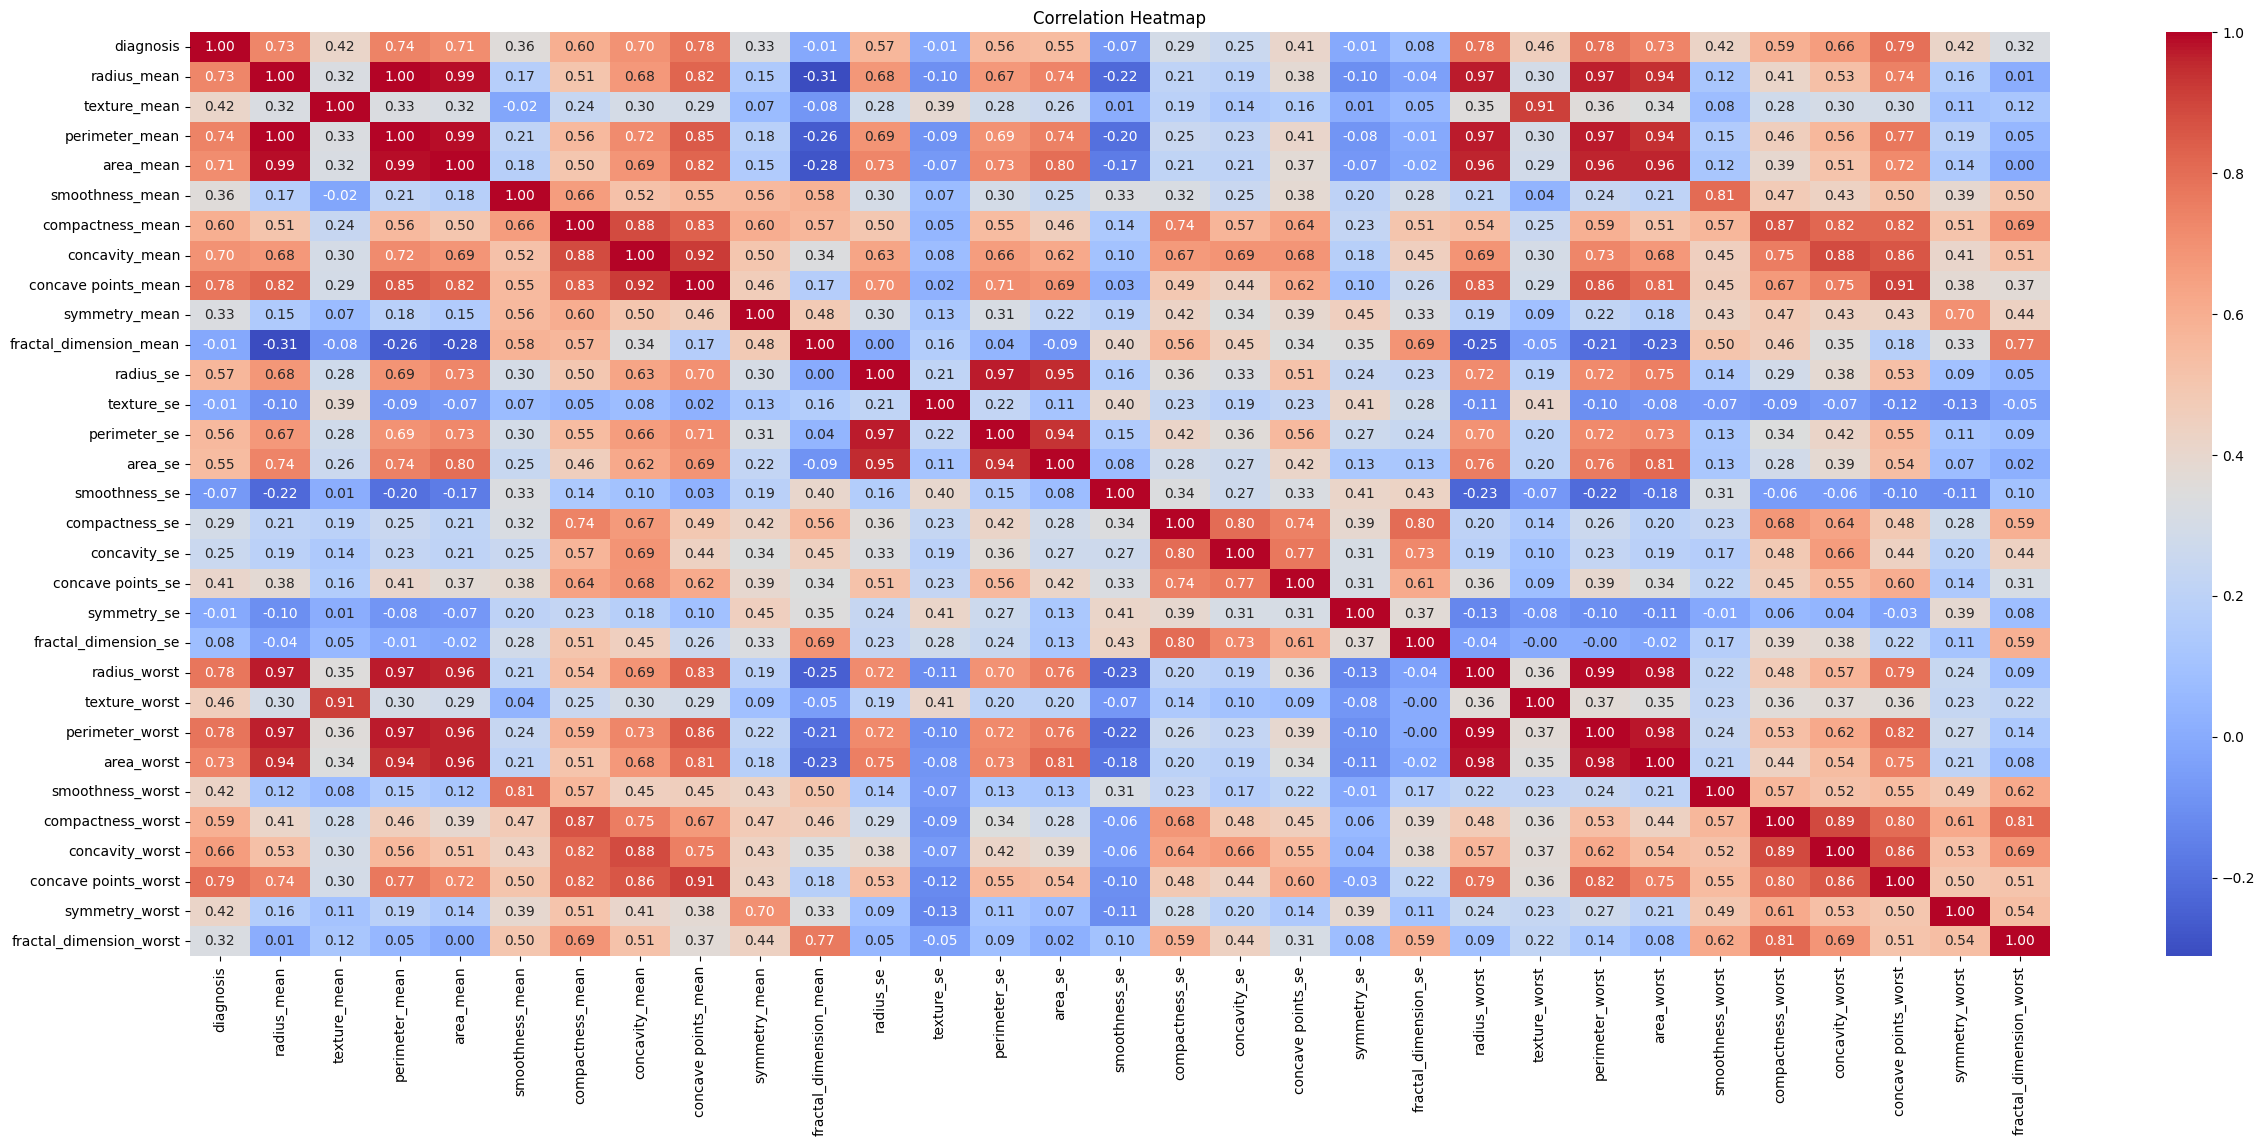

In [ ]:
correlation_matrix = diagnosis_data.corr()
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The highest correlations (>0.9) are seen between [perimeter_mean,radius_mean], [area_mean,radius_mean], [radius_worst,radius_mean], [perimeter_worst,radius_mean], [area_worst,area_mean], [conave points_worst,concave points_mean], ['perimeter_se','area_se'] and various other combinations of the same features, so we'll select these.

In [ ]:
X = diagnosis_data[['perimeter_mean','radius_mean','area_mean','radius_worst','perimeter_worst','area_worst','concave points_worst','concave points_mean','perimeter_se','area_se']] # Define predictors/features
y = diagnosis_data['diagnosis'] # Define target/label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Perform train/test split
y_train = y_train.to_numpy().reshape(-1,1) # Reshape target/label to be a single column, because the NN class likes that
y_test = y_test.to_numpy().reshape(-1,1)

scaler = StandardScaler() # Define the scaler
X_train = scaler.fit_transform(X_train) # Fit the scaler to X_train and scale it
X_test = scaler.transform(X_test) # Be sure to scale X_train and X_test separately, to prevent contamination

In [ ]:
X_train[:10]

array([[-1.36208497, -1.44075296, -1.1391179 , -1.23286131, -1.24792009,
        -0.97396758,  0.9320124 , -0.11914956, -0.47041357, -0.47476088],
       [ 2.09167167,  1.97409619,  1.85197292,  2.17331385,  2.08161691,
         2.1374055 ,  2.6989469 ,  2.66503199,  0.75195659,  0.87716951],
       [-1.34520926, -1.39998202, -1.10978518, -1.29528358, -1.24522047,
        -0.99971493, -0.97023893, -0.69650228, -0.12095781, -0.35077918],
       [-0.98258746, -0.98179678, -0.86694414, -0.8291973 , -0.87357215,
        -0.74294685, -0.80948314, -0.84511471, -0.65795   , -0.49659014],
       [-1.12500192, -1.11769991, -0.96594206, -1.08512861, -1.11713828,
        -0.89654919, -1.35458167, -0.93059974,  0.21931447, -0.11553185],
       [ 0.19953494,  0.11958479,  0.01247322,  0.25486944,  0.50983548,
         0.11676769,  0.87377865,  0.66704965,  0.01002769, -0.1594023 ],
       [ 0.17072277,  0.0827777 , -0.00952631, -0.09677601, -0.16207109,
        -0.19343495, -0.18515607,  0.46662014

In [ ]:
X_test[:10]

array([[-0.44421138, -0.46649743, -0.48646498, -0.2632354 , -0.33154752,
        -0.35109337, -0.19435087, -0.26486866, -0.17460869, -0.2072995 ],
       [ 1.30551088,  1.36536344,  1.34147086,  1.79461875,  1.76366112,
         1.7441412 ,  0.99177862,  0.82144876,  1.27009847,  1.18638199],
       [ 0.40410139,  0.38006578,  0.26659607,  0.62940306,  0.53383214,
         0.49204412,  0.57035018,  0.85722095,  0.11394607,  0.17460653],
       [-0.42857048, -0.48631664, -0.52623337, -0.69811054, -0.52472066,
        -0.63695948, -0.62037671, -0.53368618, -0.3162277 , -0.52223422],
       [-0.70928339, -0.72980974, -0.7092808 , -0.82711656, -0.84957549,
        -0.73924347, -0.68964422, -0.58760751, -0.59463229, -0.40715377],
       [ 1.98465502,  1.83536175,  1.72223207,  1.97772407,  2.32458312,
         1.66478293,  2.31123274,  2.72815939,  1.40833408,  0.97805034],
       [ 2.2768928 ,  2.23457718,  2.33427045,  2.37722659,  2.63653974,
         2.38077084,  1.97715492,  2.67818353

In [ ]:
y_train[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1]])

In [ ]:
y_test[:10]

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0]])

In [ ]:
X_train.shape[1]

10

# Sample Neural Network Testing

## Configuration 1

epocs = 100

learn_rate = .0001

batch_size = 20

val_split = .2

verbose = 1

layer_structure = [10,2,2,1]

Please note that X_train.shape[1] = 10, so these will all have an input layer of 10.

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.7564112234843852 Valid MSE: 0.7263420398723381
Epoch: 1 Train MSE: 0.7481565456779286 Valid MSE: 0.7184076380433223
Epoch: 2 Train MSE: 0.7400414512815989 Valid MSE: 0.7106087429532225
Epoch: 3 Train MSE: 0.732062824779324 Valid MSE: 0.7029423340366264
Epoch: 4 Train MSE: 0.7242176487260092 Valid MSE: 0.6954054856581081
Epoch: 5 Train MSE: 0.7165029999329833 Valid MSE: 0.6879953634212799
Epoch: 6 Train MSE: 0.7089160458222057 Valid MSE: 0.6807092206408506
Epoch: 7 Train MSE: 0.7014540409407697 Valid MSE: 0.673544394969519
Epoch: 8 Train MSE: 0.6941143236277131 Valid MSE: 0.6664983051720212
Epoch: 9 Train MSE: 0.6868943128256021 Valid MSE: 0.6595684480390588
Epoch: 10 Train MSE: 0.6797915050297684 Valid MSE: 0.6527523954342556
Epoch: 11 Train MSE: 0.672803471368482 Valid MSE: 0.6460477914676617
Epoch: 12 Train MSE: 0.6659278548077073 Valid MSE: 0.6394523497896859
Epoch: 13 Train MSE: 0.6591623674744449 Valid MSE: 0.6329638509996691
Epoch: 14 Train MSE: 0.6525047880

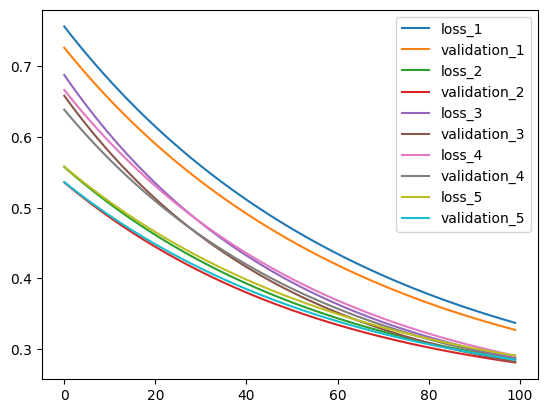

In [ ]:
configuration_1 = testNetwork(X_train, X_test, y_train, y_test, [10,2,2,1], .0001, 20, 0.2, 100, 5, 1)

In [ ]:
configuration_1

{'1': 0.3343444163863447,
 '2': 0.28450504419813794,
 '3': 0.2853404982920426,
 '4': 0.2890971529073983,
 '5': 0.28905957316696884}

## Configuration 2

epocs = 200

learn_rate = .0001

batch_size = 20

val_split = .2

verbose = 1

layer_structure = [10,6,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.541983759445984 Valid MSE: 0.5169667039464906
Epoch: 1 Train MSE: 0.5319458527898093 Valid MSE: 0.507552148474137
Epoch: 2 Train MSE: 0.5222261600013463 Valid MSE: 0.4984417195841961
Epoch: 3 Train MSE: 0.5128140956401607 Valid MSE: 0.48962528769220093
Epoch: 4 Train MSE: 0.5036995162192517 Valid MSE: 0.4810931397193807
Epoch: 5 Train MSE: 0.49487269409947143 Valid MSE: 0.47283595488130364
Epoch: 6 Train MSE: 0.48632429329306653 Valid MSE: 0.4648447822356326
Epoch: 7 Train MSE: 0.4780453470252495 Valid MSE: 0.4571110198504388
Epoch: 8 Train MSE: 0.4700272369155399 Valid MSE: 0.4496263954661834
Epoch: 9 Train MSE: 0.4622616736522346 Valid MSE: 0.442382948535055
Epoch: 10 Train MSE: 0.4547406790439057 Valid MSE: 0.4353730135309504
Epoch: 11 Train MSE: 0.447456569341385 Valid MSE: 0.428589204432117
Epoch: 12 Train MSE: 0.44040193973239317 Valid MSE: 0.4220244002864086
Epoch: 13 Train MSE: 0.43356964991888447 Valid MSE: 0.4156717317763487
Epoch: 14 Train MSE: 0.426952

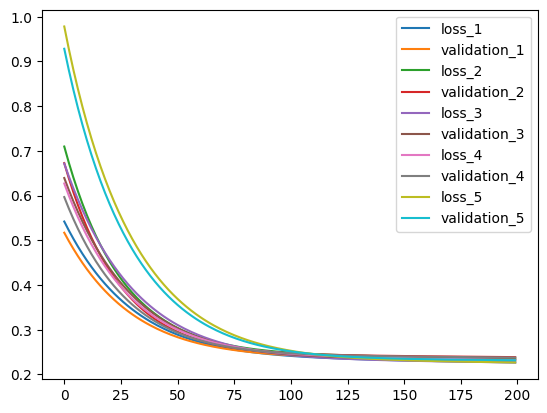

In [ ]:
configuration_2 = testNetwork(X_train, X_test, y_train, y_test, [10,6,4,1], .0001, 20, 0.2, 200, 5, 1)

In [ ]:
configuration_2

{'1': 0.22826277680083046,
 '2': 0.23474869788741615,
 '3': 0.22803358696712744,
 '4': 0.23308843924295114,
 '5': 0.22733809515783635}

## Configuration 3

epocs = 100 //It seemed to plateau ~100 epochs so I'm setting this back

learn_rate = .0001

batch_size = 30

val_split = .2

verbose = 1

layer_structure = [10,8,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.5119535835526807 Valid MSE: 0.4475550890838285
Epoch: 1 Train MSE: 0.49976634135253906 Valid MSE: 0.43749470951670755
Epoch: 2 Train MSE: 0.48802836554298534 Valid MSE: 0.4278419573432797
Epoch: 3 Train MSE: 0.4767227971066156 Valid MSE: 0.4185813115846282
Epoch: 4 Train MSE: 0.46583372819627494 Valid MSE: 0.4096980806763206
Epoch: 5 Train MSE: 0.45534611391430735 Valid MSE: 0.4011783261910299
Epoch: 6 Train MSE: 0.4452456930068511 Valid MSE: 0.39300879443353115
Epoch: 7 Train MSE: 0.4355189166012856 Valid MSE: 0.38517685513630584
Epoch: 8 Train MSE: 0.4261528842081614 Valid MSE: 0.3776704465648842
Epoch: 9 Train MSE: 0.41713528629012997 Valid MSE: 0.37047802641264815
Epoch: 10 Train MSE: 0.4084543527712977 Valid MSE: 0.3635885279266512
Epoch: 11 Train MSE: 0.4000988069225341 Valid MSE: 0.35699132076029566
Epoch: 12 Train MSE: 0.3920578241128353 Valid MSE: 0.35067617609658114
Epoch: 13 Train MSE: 0.3843209949649662 Valid MSE: 0.3446332356279767
Epoch: 14 Train MSE

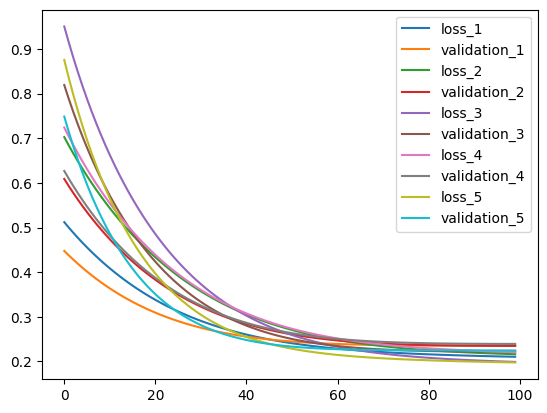

In [ ]:
configuration_3 = testNetwork(X_train, X_test, y_train, y_test, [10,8,4,1], .0001, 30, 0.2, 100, 5, 1)

In [ ]:
configuration_3

{'1': 0.2288689545851864,
 '2': 0.23043707261217344,
 '3': 0.21555888894883093,
 '4': 0.2349185116678236,
 '5': 0.21813551983572016}

## Configuration 4

epocs = 100

learn_rate = .0003

batch_size = 30

val_split = .2

verbose = 1

layer_structure = [10,8,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 1.1194042403949265 Valid MSE: 0.9004053825913286
Epoch: 1 Train MSE: 0.9806996006664841 Valid MSE: 0.7913047685148961
Epoch: 2 Train MSE: 0.865771047982302 Valid MSE: 0.7007908441529153
Epoch: 3 Train MSE: 0.7693787060543344 Valid MSE: 0.6250140577151589
Epoch: 4 Train MSE: 0.6877914067631122 Valid MSE: 0.5611724962355009
Epoch: 5 Train MSE: 0.6182775800198766 Valid MSE: 0.5071700718076059
Epoch: 6 Train MSE: 0.5587832955425802 Valid MSE: 0.46139629368060736
Epoch: 7 Train MSE: 0.5077233111673272 Valid MSE: 0.42258137402596535
Epoch: 8 Train MSE: 0.46384271610227434 Valid MSE: 0.38969940607861164
Epoch: 9 Train MSE: 0.4261239571515335 Valid MSE: 0.3619029550639067
Epoch: 10 Train MSE: 0.39372371698006103 Valid MSE: 0.3384785363980134
Epoch: 11 Train MSE: 0.36592975852086385 Valid MSE: 0.31881613080682875
Epoch: 12 Train MSE: 0.34213125735573546 Valid MSE: 0.30238816687308284
Epoch: 13 Train MSE: 0.32179827449987713 Valid MSE: 0.2887348682218436
Epoch: 14 Train MSE: 

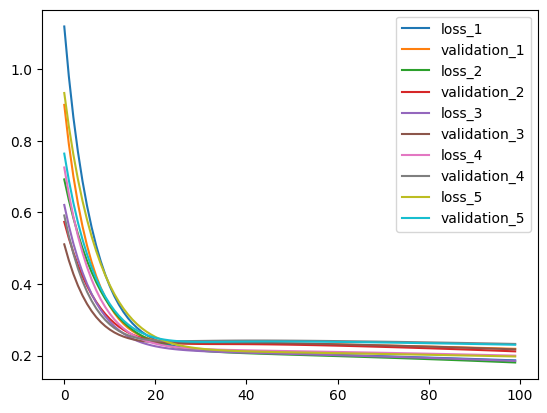

In [ ]:
configuration_4 = testNetwork(X_train, X_test, y_train, y_test, [10,8,4,1], .0003, 30, 0.2, 100, 5, 1)

In [ ]:
configuration_4

{'1': 0.21032721987400702,
 '2': 0.20369099668342017,
 '3': 0.20855765651959088,
 '4': 0.22448926623408486,
 '5': 0.22101399273649297}

## Configuration 5

epocs = 100

learn_rate = .001

batch_size = 30

val_split = .2

verbose = 1

layer_structure = [10,8,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.6875440336001054 Valid MSE: 0.4331262282206302
Epoch: 1 Train MSE: 0.4439649183679365 Valid MSE: 0.3158687530327467
Epoch: 2 Train MSE: 0.3220562019076608 Valid MSE: 0.2638653094905151
Epoch: 3 Train MSE: 0.2623509827467148 Valid MSE: 0.24325621925416357
Epoch: 4 Train MSE: 0.234055965002488 Valid MSE: 0.23653753019365412
Epoch: 5 Train MSE: 0.22090803940235618 Valid MSE: 0.23522957511462758
Epoch: 6 Train MSE: 0.21471726654735016 Valid MSE: 0.2356037296518816
Epoch: 7 Train MSE: 0.2115942485466349 Valid MSE: 0.23620951822286446
Epoch: 8 Train MSE: 0.20978226496912222 Valid MSE: 0.23658412879087012
Epoch: 9 Train MSE: 0.20851745090469243 Valid MSE: 0.23664935980631838
Epoch: 10 Train MSE: 0.20747663347932513 Valid MSE: 0.23644872805636605
Epoch: 11 Train MSE: 0.2065256661220943 Valid MSE: 0.2360468511051776
Epoch: 12 Train MSE: 0.20560950986768733 Valid MSE: 0.23550328907934537
Epoch: 13 Train MSE: 0.20470562024098782 Valid MSE: 0.23486261870214517
Epoch: 14 Train

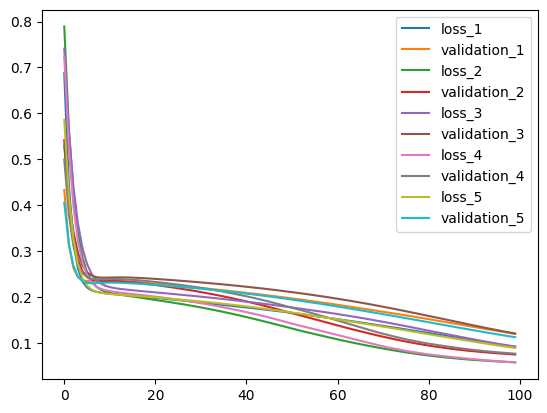

In [ ]:
configuration_5 = testNetwork(X_train, X_test, y_train, y_test, [10,8,4,1], .001, 30, 0.2, 100, 5, 1)

In [ ]:
configuration_5

{'1': 0.1100359909366058,
 '2': 0.06720564513660918,
 '3': 0.11208795124645714,
 '4': 0.06910296595276233,
 '5': 0.10612916193440874}

## Configuration 6

epocs = 100

learn_rate = .001

batch_size = 20

val_split = .2

verbose = 1

layer_structure = [10,8,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.42873626884528526 Valid MSE: 0.3735052670728983
Epoch: 1 Train MSE: 0.37186159317696266 Valid MSE: 0.33205633616712954
Epoch: 2 Train MSE: 0.33145138506906574 Valid MSE: 0.30308649407267024
Epoch: 3 Train MSE: 0.3029903428606302 Valid MSE: 0.2830892713488829
Epoch: 4 Train MSE: 0.2831304627432013 Valid MSE: 0.2694530566636753
Epoch: 5 Train MSE: 0.2693769895865502 Valid MSE: 0.26024897755264215
Epoch: 6 Train MSE: 0.25989007747395926 Valid MSE: 0.25407712030190427
Epoch: 7 Train MSE: 0.2533367661295207 Valid MSE: 0.24994262216596294
Epoch: 8 Train MSE: 0.24877064564230372 Valid MSE: 0.24715347264918086
Epoch: 9 Train MSE: 0.24553295792358582 Valid MSE: 0.24523800520889702
Epoch: 10 Train MSE: 0.24317338892279278 Valid MSE: 0.24388067834172603
Epoch: 11 Train MSE: 0.24138893288922708 Valid MSE: 0.2428739517641515
Epoch: 12 Train MSE: 0.23997840700608147 Valid MSE: 0.2420834376303505
Epoch: 13 Train MSE: 0.23880969308991995 Valid MSE: 0.2414233936278329
Epoch: 14 Tr

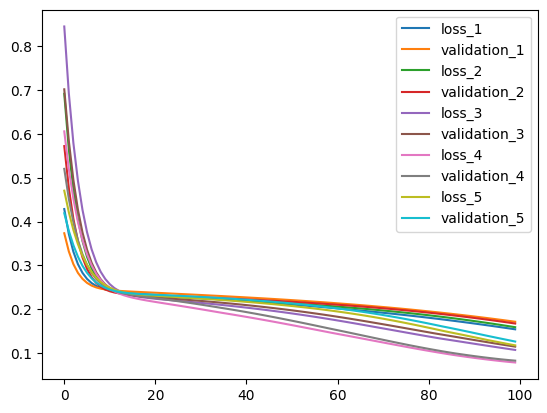

In [ ]:
configuration_6 = testNetwork(X_train, X_test, y_train, y_test, [10,8,4,1], .001, 20, 0.2, 100, 5, 1)

In [ ]:
configuration_6

{'1': 0.15993793736561987,
 '2': 0.15888780697107213,
 '3': 0.10684277783242016,
 '4': 0.07498313056916012,
 '5': 0.11667148298236966}

## Configuration 7

epocs = 100

learn_rate = .001

batch_size = 30

val_split = .2

verbose = 1

layer_structure = [10,8,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.4414569951288467 Valid MSE: 0.47497937217159386
Epoch: 1 Train MSE: 0.3560531203420694 Valid MSE: 0.3933644790060333
Epoch: 2 Train MSE: 0.3101202808811838 Valid MSE: 0.3438561817246578
Epoch: 3 Train MSE: 0.28557648743071573 Valid MSE: 0.313324771724566
Epoch: 4 Train MSE: 0.27249002820913854 Valid MSE: 0.29409377782225776
Epoch: 5 Train MSE: 0.2654092582351009 Valid MSE: 0.2816536981334476
Epoch: 6 Train MSE: 0.2614091818723477 Valid MSE: 0.2733517352048156
Epoch: 7 Train MSE: 0.25896210222123717 Valid MSE: 0.2676167581633579
Epoch: 8 Train MSE: 0.2572887671842897 Valid MSE: 0.2635054557087825
Epoch: 9 Train MSE: 0.25599881613184877 Valid MSE: 0.26044069812070786
Epoch: 10 Train MSE: 0.254899038652736 Valid MSE: 0.2580618305600467
Epoch: 11 Train MSE: 0.2538943390215601 Valid MSE: 0.2561386943250305
Epoch: 12 Train MSE: 0.25293780947993444 Valid MSE: 0.25452157244933604
Epoch: 13 Train MSE: 0.2520059983847915 Valid MSE: 0.25311144732641444
Epoch: 14 Train MSE: 0

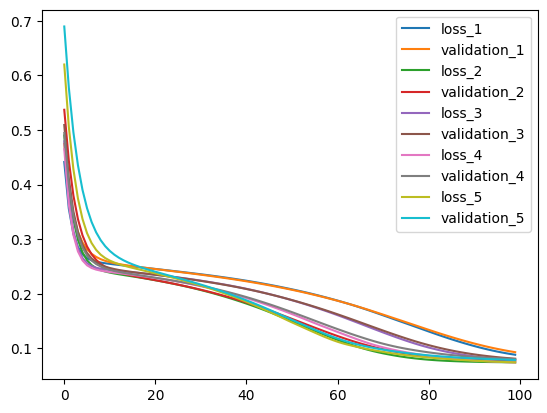

In [ ]:
configuration_7 = testNetwork(X_train, X_test, y_train, y_test, [10,8,4,1], .001, 30, 0.1, 100, 5, 1)

In [ ]:
configuration_7

{'1': 0.08539061199289268,
 '2': 0.0688288962329836,
 '3': 0.07405914928686297,
 '4': 0.06886596334813615,
 '5': 0.06732733562178327}

## Configuration 8

epocs = 100

learn_rate = .003

batch_size = 20

val_split = .2

verbose = 1

layer_structure = [10,8,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.5580588429887919 Valid MSE: 0.35293459206169603
Epoch: 1 Train MSE: 0.331293158545283 Valid MSE: 0.2637632190371477
Epoch: 2 Train MSE: 0.25608959542837884 Valid MSE: 0.23954086938367664
Epoch: 3 Train MSE: 0.2341950260580293 Valid MSE: 0.23388999839982086
Epoch: 4 Train MSE: 0.22780809564166904 Valid MSE: 0.23222380160859996
Epoch: 5 Train MSE: 0.22511479961102004 Valid MSE: 0.2310311870124911
Epoch: 6 Train MSE: 0.22310500541809797 Valid MSE: 0.2296744179009721
Epoch: 7 Train MSE: 0.22110231633194977 Valid MSE: 0.22809421108838182
Epoch: 8 Train MSE: 0.21901864362709908 Valid MSE: 0.22641519339699073
Epoch: 9 Train MSE: 0.21711192260183382 Valid MSE: 0.22465176214103966
Epoch: 10 Train MSE: 0.21508954986496173 Valid MSE: 0.22269860935498592
Epoch: 11 Train MSE: 0.21287817849207946 Valid MSE: 0.22054637969042154
Epoch: 12 Train MSE: 0.21045627951179724 Valid MSE: 0.2181780694074437
Epoch: 13 Train MSE: 0.20780035948050238 Valid MSE: 0.21557220892243256
Epoch: 14 

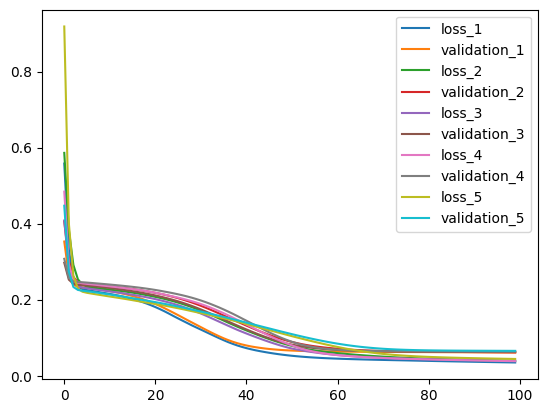

In [ ]:
configuration_8 = testNetwork(X_train, X_test, y_train, y_test, [10,8,4,1], .003, 20, 0.2, 100, 5, 1)

In [ ]:
configuration_8

{'1': 0.04901378591703408,
 '2': 0.047861412172660524,
 '3': 0.05376022828870182,
 '4': 0.05562225485196319,
 '5': 0.05710322718216187}

## Configuration 9

epocs = 100

learn_rate = .003

batch_size = 20

val_split = .2

verbose = 1

layer_structure = [10,6,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.46780707334678345 Valid MSE: 0.3173179271786429
Epoch: 1 Train MSE: 0.3009665882643566 Valid MSE: 0.25312129861243426
Epoch: 2 Train MSE: 0.2452145347984164 Valid MSE: 0.23516853390658793
Epoch: 3 Train MSE: 0.22778425038477434 Valid MSE: 0.230405336732569
Epoch: 4 Train MSE: 0.22175191969688282 Valid MSE: 0.22856518389909122
Epoch: 5 Train MSE: 0.21867755590539073 Valid MSE: 0.22712101402862409
Epoch: 6 Train MSE: 0.21642157409011747 Valid MSE: 0.22558029472006869
Epoch: 7 Train MSE: 0.21426920665700872 Valid MSE: 0.22384273912010133
Epoch: 8 Train MSE: 0.212049668046887 Valid MSE: 0.22193752045191126
Epoch: 9 Train MSE: 0.20972649517770542 Valid MSE: 0.21988718302902907
Epoch: 10 Train MSE: 0.2072860667589752 Valid MSE: 0.21770934200269765
Epoch: 11 Train MSE: 0.2047190354410881 Valid MSE: 0.21541309160773464
Epoch: 12 Train MSE: 0.2020736449710166 Valid MSE: 0.21306100787099366
Epoch: 13 Train MSE: 0.19949795312951124 Valid MSE: 0.2106183590450211
Epoch: 14 Tra

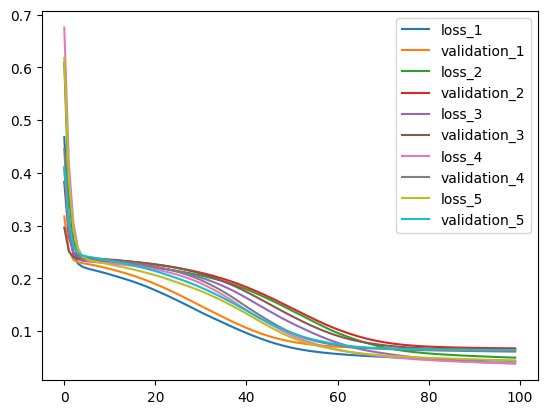

In [ ]:
configuration_9 = testNetwork(X_train, X_test, y_train, y_test, [10,6,4,1], .003, 20, 0.2, 100, 5, 1)

In [ ]:
configuration_9

{'1': 0.05637229203192557,
 '2': 0.0580265184733377,
 '3': 0.04758234003529528,
 '4': 0.04249739109648328,
 '5': 0.05680189571689142}

## Configuration 10

epocs = 100

learn_rate = .003

batch_size = 20

val_split = .2

verbose = 1

layer_structure = [10,6,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.8982857334931624 Valid MSE: 0.48444009846262226
Epoch: 1 Train MSE: 0.4846911710588341 Valid MSE: 0.3069149871884885
Epoch: 2 Train MSE: 0.3086594400428581 Valid MSE: 0.2281185423608483
Epoch: 3 Train MSE: 0.23001768344935364 Valid MSE: 0.1899319878155387
Epoch: 4 Train MSE: 0.19152400198713876 Valid MSE: 0.16874587918545308
Epoch: 5 Train MSE: 0.16987970757779858 Valid MSE: 0.15491821371228584
Epoch: 6 Train MSE: 0.15567219895283918 Valid MSE: 0.14464048188338438
Epoch: 7 Train MSE: 0.14509005681359705 Valid MSE: 0.13611751897063948
Epoch: 8 Train MSE: 0.13627653190926853 Valid MSE: 0.12865695323627235
Epoch: 9 Train MSE: 0.12852001420522058 Valid MSE: 0.12196862389663171
Epoch: 10 Train MSE: 0.12151240956651552 Valid MSE: 0.1159524322956404
Epoch: 11 Train MSE: 0.11515942502462775 Valid MSE: 0.1107624438828491
Epoch: 12 Train MSE: 0.109763675578434 Valid MSE: 0.10602896328822096
Epoch: 13 Train MSE: 0.10477617641696362 Valid MSE: 0.10174725287330771
Epoch: 14 Tr

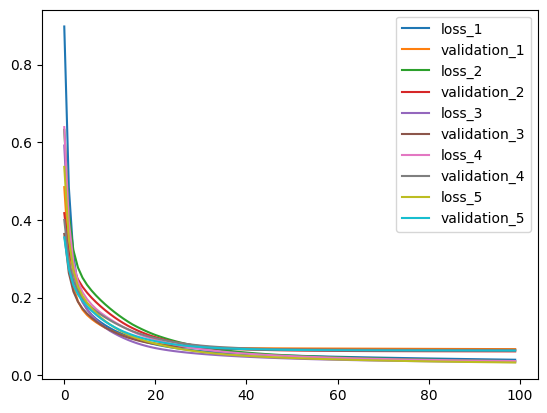

In [ ]:
configuration_10 = testNetwork(X_train, X_test, y_train, y_test, [10,6,1], .003, 20, 0.2, 100, 5, 1)

In [ ]:
configuration_10

{'1': 0.05938756508019397,
 '2': 0.05301006847278057,
 '3': 0.05903522347028785,
 '4': 0.05734570790063487,
 '5': 0.05488819632411739}

## Configuration 11

epocs = 100

learn_rate = .003

batch_size = 20

val_split = .1

verbose = 1

layer_structure = [10,8,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.4508190356333789 Valid MSE: 0.4136968628112329
Epoch: 1 Train MSE: 0.31146672062534675 Valid MSE: 0.3160368262560494
Epoch: 2 Train MSE: 0.2665374263302863 Valid MSE: 0.27570534771875727
Epoch: 3 Train MSE: 0.25194374846972956 Valid MSE: 0.25764431874768584
Epoch: 4 Train MSE: 0.24619624404628565 Valid MSE: 0.24843065262957384
Epoch: 5 Train MSE: 0.24278573332570857 Valid MSE: 0.24289817387586846
Epoch: 6 Train MSE: 0.2399308753497666 Valid MSE: 0.23895315561501282
Epoch: 7 Train MSE: 0.23716149980824258 Valid MSE: 0.23568708776712663
Epoch: 8 Train MSE: 0.23434157141167633 Valid MSE: 0.23268848224816008
Epoch: 9 Train MSE: 0.2314161768624084 Valid MSE: 0.22977885000118872
Epoch: 10 Train MSE: 0.22834931540256548 Valid MSE: 0.2268190366290267
Epoch: 11 Train MSE: 0.2251087875847189 Valid MSE: 0.22374511324404503
Epoch: 12 Train MSE: 0.22166235658990413 Valid MSE: 0.2205137029694955
Epoch: 13 Train MSE: 0.21797661659126266 Valid MSE: 0.21709067175729027
Epoch: 14 T

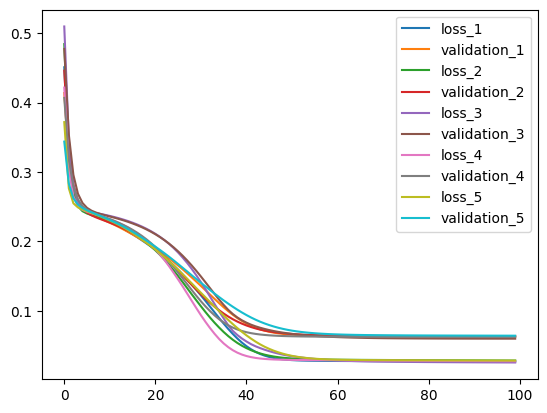

In [ ]:
configuration_11 = testNetwork(X_train, X_test, y_train, y_test, [10,8,4,1], .003, 20, 0.1, 100, 5, 1)

In [ ]:
configuration_11

{'1': 0.05729129308858626,
 '2': 0.058249352939819456,
 '3': 0.05164102208538017,
 '4': 0.0587008288659867,
 '5': 0.057278225285238245}

## Configuration 12

epocs = 100

learn_rate = .003

batch_size = 40

val_split = .2

verbose = 1

layer_structure = [10,8,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.46284595473017576 Valid MSE: 0.23553231870666036
Epoch: 1 Train MSE: 0.2108083140146552 Valid MSE: 0.2387553398668294
Epoch: 2 Train MSE: 0.19546915434015733 Valid MSE: 0.2394314238968885
Epoch: 3 Train MSE: 0.19235055401393378 Valid MSE: 0.23667540047505106
Epoch: 4 Train MSE: 0.18912757076714226 Valid MSE: 0.2333073199461828
Epoch: 5 Train MSE: 0.18571010028732787 Valid MSE: 0.22959937213628817
Epoch: 6 Train MSE: 0.18209279945699197 Valid MSE: 0.22555327769286507
Epoch: 7 Train MSE: 0.17818293969205734 Valid MSE: 0.22110284896171684
Epoch: 8 Train MSE: 0.17392244964023013 Valid MSE: 0.21620216188480318
Epoch: 9 Train MSE: 0.16933636226554843 Valid MSE: 0.21092472475231364
Epoch: 10 Train MSE: 0.16444258922679522 Valid MSE: 0.20520000575397518
Epoch: 11 Train MSE: 0.1591355998107512 Valid MSE: 0.19895864596389162
Epoch: 12 Train MSE: 0.15341113628256348 Valid MSE: 0.19227175991920814
Epoch: 13 Train MSE: 0.14738833412514024 Valid MSE: 0.1852562048748955
Epoch: 1

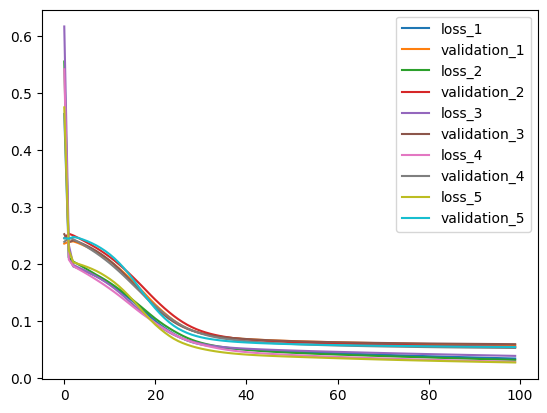

In [ ]:
configuration_12 = testNetwork(X_train, X_test, y_train, y_test, [10,8,4,1], .003, 40, 0.2, 100, 5, 1) # Setting the learning rate higher than .003 tends to result in the MSE skyrocketing and the model falling apart

In [ ]:
configuration_12

{'1': 0.04450539631352577,
 '2': 0.03928960521556605,
 '3': 0.049870375941915554,
 '4': 0.03442879215741348,
 '5': 0.03468927084461254}

## Configuration 13

epocs = 100

learn_rate = .003

batch_size = 40

val_split = .2

verbose = 1

layer_structure = [10,8,6,4,1]

iterations = 5

verbose = 1

Epoch: 0 Train MSE: 0.3771483111413392 Valid MSE: 0.2412255385736443
Epoch: 1 Train MSE: 0.20494043358663092 Valid MSE: 0.2468811986738231
Epoch: 2 Train MSE: 0.20421991553256846 Valid MSE: 0.2469027689142747
Epoch: 3 Train MSE: 0.2039950267259871 Valid MSE: 0.2466922290699142
Epoch: 4 Train MSE: 0.20375715449964604 Valid MSE: 0.24646100687878933
Epoch: 5 Train MSE: 0.2035042071536403 Valid MSE: 0.24621398848399365
Epoch: 6 Train MSE: 0.20323444062611634 Valid MSE: 0.24594958407148995
Epoch: 7 Train MSE: 0.20294592671637876 Valid MSE: 0.24566581881977248
Epoch: 8 Train MSE: 0.202636525940651 Valid MSE: 0.24536048627064458
Epoch: 9 Train MSE: 0.2023038570199984 Valid MSE: 0.24503112039883862
Epoch: 10 Train MSE: 0.20194526180697212 Valid MSE: 0.24467495727423846
Epoch: 11 Train MSE: 0.20155776486899626 Valid MSE: 0.24428889043116478
Epoch: 12 Train MSE: 0.2011380268133694 Valid MSE: 0.2438694189853522
Epoch: 13 Train MSE: 0.20068229028025114 Valid MSE: 0.24341541376303336
Epoch: 14 Trai

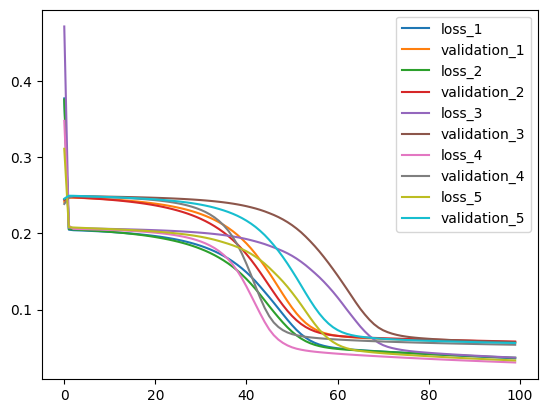

In [ ]:
configuration_13 = testNetwork(X_train, X_test, y_train, y_test, [10,8,6,4,1], .003, 40, 0.2, 100, 5, 1)

In [ ]:
configuration_13

{'1': 0.04424640808767036,
 '2': 0.04401559108720762,
 '3': 0.041034496814988566,
 '4': 0.03536586164567949,
 '5': 0.038562622642485264}

# Sample Neural Network Testing Results

In [ ]:
for configuration in results:
  error = []
  for result in results[configuration].items():
    error.append(result[1])
  mean_error = np.mean(error)
  results[configuration]['mean_test_error'] = mean_error

results_pd = pd.DataFrame.from_dict(results, orient='index')

results_pd

,1,2,3,4,5,mean_test_error
"[10, 2, 2, 1] - 0.0001 - 20 - 0.2 - 100",0.334344,0.284505,0.285340,0.289097,0.289060,0.296469
"[10, 6, 4, 1] - 0.0001 - 20 - 0.2 - 200",0.228263,0.234749,0.228034,0.233088,0.227338,0.230294
"[10, 8, 4, 1] - 0.0001 - 30 - 0.2 - 100",0.228869,0.230437,0.215559,0.234919,0.218136,0.225584
"[10, 8, 4, 1] - 0.0003 - 30 - 0.2 - 100",0.210327,0.203691,0.208558,0.224489,0.221014,0.213616
"[10, 8, 4, 1] - 0.001 - 30 - 0.2 - 100",0.110036,0.067206,0.112088,0.069103,0.106129,0.092912
"[10, 8, 4, 1] - 0.001 - 20 - 0.2 - 100",0.159938,0.158888,0.106843,0.074983,0.116671,0.123465
"[10, 8, 4, 1] - 0.001 - 30 - 0.1 - 100",0.085391,0.068829,0.074059,0.068866,0.067327,0.072894
"[10, 8, 4, 1] - 0.003 - 20 - 0.2 - 100",0.049014,0.047861,0.053760,0.055622,0.057103,0.052672
"[10, 6, 4, 1] - 0.003 - 20 - 0.2 - 100",0.056372,0.058027,0.047582,0.042497,0.056802,0.052256
"[10, 6, 1] - 0.003 - 20 - 0.2 - 100",0.059388,0.053010,0.059035,0.057346,0.054888,0.056733
